# Exercise – implementation of FBA problem

In [25]:
# Import dos módulos e bibliotecas necessários

import cobra
from cobra.flux_analysis import flux_variability_analysis
import mewpy
from mewpy.simulation import get_simulator
from mewpy.visualization.envelope import plot_flux_envelope
from mewpy.omics import ExpressionSet, eFlux
from mewpy.optimization.evaluation import  BPCY, WYIELD
from mewpy.problems import RKOProblem
from mewpy.problems import ROUProblem
from mewpy.optimization import EA
import pandas as pd

In [12]:
# Import do modelo
model_path = 'iRC1080_lv3.xml'
model = cobra.io.read_sbml_model(model_path)
model

Name,iRC1080
Memory address,7f04c6e3d7e0
Number of metabolites,1706
Number of reactions,2191
Number of genes,1086
Number of groups,0
Objective expression,1.0*BIOMASS_Chlamy_hetero - 1.0*BIOMASS_Chlamy_hetero_reverse_b1c3b
Compartments,"cytosol, mitochondria, chloroplast, flagellum, peroxisome/glyoxysome, nucleus, golgi apparatus, extracellular space, eyespot, thylakoid"


## **Exercício 1**

### Alínea A)

In [13]:
model.summary()

# Verificação das reações...da taxa de crescimento...
objectivo = model.optimize()
print("condições iniciais, taxa de crescimento máximo nestas condições:", objectivo.objective_value)

# e das reações
for exchange in model.exchanges:
    print(exchange.name, exchange.id, '->', exchange.bounds)
    
# Cópia do modelo e definição do objectivo para as condições Aerobic autotrophic
model_aeroauto = model.copy()
model_aeroauto.objective = 'BIOMASS_Chlamy_auto'

# Alterar as bounds para correspondência com as novas condições de cultura
model_aeroauto.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_aeroauto.reactions.get_by_id("EX_co2_e").lower_bound = -11.16
model_aeroauto.reactions.get_by_id("EX_o2_e").lower_bound = -10
model_aeroauto.reactions.get_by_id("EX_ac_e").lower_bound = 0
model_aeroauto.reactions.get_by_id("SK_starch300_h").lower_bound = 0

# Cópia do modelo e definição do objectivo para as condições Microaerobic autotrophic
'''
Ao usar o modelo anterior e apenas alterando a lower bound do oxigenio evito repetição de passos no código. desvantagem : um modelo depende da existência do outro
'''
model_microauto = model_aeroauto.copy()

# Alterar as bounds para correspondência com as novas condições de cultura
model_microauto.reactions.get_by_id("EX_o2_e").lower_bound = -0.01

# Cópia do modelo e definição do objectivo para as condições Aerobic heterotrophic
model_aerohet = model.copy()
model_aerohet.objective = 'BIOMASS_Chlamy_hetero'

# Alteração das "bounds", para corresponder à nossa simulação das novas condições de cultura <- Aerobic heterotrophic
model_aerohet.reactions.get_by_id("EX_photonVis_e").lower_bound = 0
model_aerohet.reactions.get_by_id("EX_co2_e").lower_bound = -11.16
model_aerohet.reactions.get_by_id("EX_o2_e").lower_bound = -10
model_aerohet.reactions.get_by_id("EX_ac_e").lower_bound = -10
model_aerohet.reactions.get_by_id("SK_starch300_h").lower_bound = -0.000172

# Reações que começam com "PRISM" ou "DM" -> fontes de luz
for search1 in model_aerohet.reactions:
    if search1.id.startswith("PRISM"):
        print(search1.id)
for search2 in model_aerohet.reactions:
    if search2.id.startswith("DM_photon"):
        print(search2.id)
        
# Alteração das reações "PRISM" e "DM_photon" para (0,0) -> ausência de luz
model_aerohet.reactions.get_by_id("DM_photon680_u").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon673_u").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon646_h").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon490_s").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon450_h").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon438_u").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon437_u").bounds = (0, 0)
model_aerohet.reactions.get_by_id("DM_photon298_c").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_design_growth").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_red_LED_674nm").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_red_LED_array_653nm").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_white_LED").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_growth_room").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_high_pressure_sodium").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_metal_halide").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_fluorescent_cool_215W").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_fluorescent_warm_18W").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_incandescent_60W").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_solar_exo").bounds = (0, 0)
model_aerohet.reactions.get_by_id("PRISM_solar_litho").bounds = (0, 0)

# Cópia do modelo e definição do objectivo para as condições Microaerobic heterotrophic
'''
Ao usar o modelo anterior e apenas alterando a lower bound do oxigenio evito repetição de passos no código. desvantagem : um modelo depende da existência do outro
'''
model_microhet = model_aerohet.copy()

# Alterar as bounds para correspondência com as novas condições de cultura
model_microhet.reactions.get_by_id("EX_o2_e").lower_bound = -0.01

#Cópia do modelo e definição do objectivo para as condições Aerobic mixotrophic
model_aeromixo = model.copy()
model_aeromixo.objective = 'BIOMASS_Chlamy_mixo'

# Alterar as bounds para correspondência com as novas condições de cultura
model_aeromixo.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_aeromixo.reactions.get_by_id("EX_co2_e").lower_bound = -11.16
model_aeromixo.reactions.get_by_id("EX_o2_e").lower_bound = -10
model_aeromixo.reactions.get_by_id("EX_ac_e").lower_bound = -10
model_aeromixo.reactions.get_by_id("SK_starch300_h").lower_bound = -0.000172

# Cópia do modelo e definição do objectivo para as condições Microaerobic mixotrophic
'''
Ao usar o modelo anterior e apenas alterando a lower bound do oxigenio evito repetição de passos no código. desvantagem : um modelo depende da existência do outro
'''
model_micromixo = model_aeromixo.copy()

# Alterar as bounds para correspondência com as novas condições de cultura
model_micromixo.reactions.get_by_id("EX_o2_e").lower_bound = -0.01


condições iniciais, taxa de crescimento máximo nestas condições: 6.373327833117038
Hypoxanthine exchange EX_hxan_e -> (0.0, 1000.0)
Allantoin exchange EX_alltn_e -> (0.0, 1000.0)
Ornithine exchange EX_orn_e -> (0.0, 1000.0)
L-Glutamine exchange EX_gln__L_e -> (0.0, 1000.0)
Urate exchange EX_urate_e -> (0.0, 1000.0)
Sulfite exchange EX_so3_e -> (0.0, 1000.0)
EX s LPAREN e RPAREN EX_s_e -> (0.0, 1000.0)
Nitrate exchange EX_no3_e -> (-10.0, 1000.0)
Sulfate exchange EX_so4_e -> (-10.0, 1000.0)
Fe2+ exchange EX_fe2_e -> (-10.0, 1000.0)
Fe3+ exchange EX_fe3_e -> (-10.0, 1000.0)
Selenite exchange EX_slnt_e -> (0.0, 1000.0)
L-Leucine exchange EX_leu__L_e -> (0.0, 1000.0)
Ethanol exchange EX_etoh_e -> (0.0, 1000.0)
L-Arginine exchange EX_arg__L_e -> (0.0, 1000.0)
Formate exchange EX_for_e -> (0.0, 1000.0)
H2 exchange EX_h2_e -> (0.0, 1000.0)
Glycolate exchange EX_glyclt_e -> (0.0, 1000.0)
Succinate exchange EX_succ_e -> (0.0, 1000.0)
D-lactate exchange EX_lac__D_e -> (0.0, 1000.0)
6-mercaptopur

####  Condição 1 - Aerobic Autotrophic - model_aeroauto
        


#####  Função objetivo: “BIOMASS_Chlamy_auto”
    Parametros: 
        photon : -2000
        CO2 : -11.16
        O2 : -10
        Acetate : 0
        Starch : 0

In [14]:
#Aerobic Autotrophic
condicao1 = model_aeroauto.optimize()
print("Aerobic autotrophic, taxa de crescimento máximo nestas condições:", condicao1.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Aerobic Autotrophic
model_aeroauto.summary()

Aerobic autotrophic, taxa de crescimento máximo nestas condições: 0.15800954440202625


Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,6.053,1,100.00%
h2o_e,EX_h2o_e,4.504,0,0.00%
mg2_e,EX_mg2_e,0.004208,0,0.00%
na1_e,EX_na1_e,1.205,0,0.00%
nh4_e,EX_nh4_e,0.5133,0,0.00%
no3_e,EX_no3_e,0.07161,0,0.00%
o2_e,EX_o2_e,1.77,0,0.00%
photonVis_e,EX_photonVis_e,1401,0,0.00%
pi_e,EX_pi_e,0.1628,0,0.00%
so4_e,EX_so4_e,0.003041,0,0.00%


#####  Metabolitos consumidos: confirmar os compostos!
    co2_e → Dióxido de Carbono
    h2o_e → Água
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Sulfato
    so4_e → Sulfato
e fotões de luz no espectro visivel, com preferência para certos comprimentos de onda (ver fotoes secretados)
#####  Metabolitos secretados:
    na1_c → Sódio
    na1_h → Sódio
    no_h → Óxido Nítrico
    o2D_u → Oxigénio
    h_e → Hidrogénio
e alguns fotoes correspondentes a certos comprimentos de onda de luz que não foram absorvidos pela microalga → derivado dos pigmentos predominantes nesta espécie?

####  Condição 2 - Microaerobic autotrophic - model_microauto

#####  Função objetivo: “BIOMASS_Chlamy_auto”
    Parametros: 
        photon : -2000
        CO2 : -11.16
        O2 : -0.01
        Acetate : 0
        Starch : 0

In [15]:
#Microaerobic autotrophic
condicao2 = model_microauto.optimize()
print("Microaerobic autotrophic, taxa de crescimento máximo nestas condições:", condicao2.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Microaerobic autotrophic
model_microauto.summary()

Microaerobic autotrophic, taxa de crescimento máximo nestas condições: 0.01083273533885239


Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.415,1,100.00%
h2o_e,EX_h2o_e,0.4999,0,0.00%
mg2_e,EX_mg2_e,0.0002885,0,0.00%
na1_e,EX_na1_e,0.3951,0,0.00%
nh4_e,EX_nh4_e,0.02122,0,0.00%
no3_e,EX_no3_e,0.2005,0,0.00%
o2_e,EX_o2_e,0.01,0,0.00%
photonVis_e,EX_photonVis_e,1401,0,0.00%
pi_e,EX_pi_e,0.01116,0,0.00%
so4_e,EX_so4_e,0.0002085,0,0.00%


#####  Metabolitos consumidos:
    ac_e → Acetato
    co2_e → Dióxido de Carbono
    h2o_e → Água    
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Fosfato
    so4_e → Sulfato
    starch300_h → Amido
#####  Metabolitos secretados:
    na1_x → Sódio
    o2D_u → Oxigénio	
    etoh_e → Etanol
    no2_e → Dióxido de Azoto
    succ_e → Sucinato


####  Condição 3 - Aerobic Heterotrophic - model_aerohet

#####  Função objetivo: “BIOMASS_Chlamy_hetero”
    Parametros: 
        photon : 0
        CO2 : -11.16
        O2 : -10
        Acetate : -10
        Starch : -1.72e-04

In [16]:
#Aerobic heterotrophic
condicao3 = model_aerohet.optimize()
print("Aerobic heterotrophic, taxa de crescimento máximo nestas condições:", condicao3.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Aerobic heterotrophic
model_aerohet.summary()

Aerobic heterotrophic, taxa de crescimento máximo nestas condições: 0.32300986517050023


Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,10,2,100.00%
mg2_e,EX_mg2_e,0.009365,0,0.00%
na1_e,EX_na1_e,1.495,0,0.00%
nh4_e,EX_nh4_e,1.014,0,0.00%
no3_e,EX_no3_e,0.8632,0,0.00%
o2_e,EX_o2_e,10,0,0.00%
pi_e,EX_pi_e,0.3327,0,0.00%
so4_e,EX_so4_e,0.01165,0,0.00%
starch300_h,SK_starch300_h,0.000172,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux


#####  Metabolitos consumidos:
    ac_e → Acetato
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Fosfato
    so4_e	→ Sulfato
    starch300_h → Amido
#####  Metabolitos secretados:
    na1_x → Sódio
    co2_e → Dióxido de Carbono
    etoh_e → Etanol
    h2o_e → Água
    h_e → Hidrogénio
    no2_e → Dióxido de Azoto

####  Condição 4 - Microaerobic Heterotrophic - model_microhet

#####  Função objetivo: “BIOMASS_Chlamy_hetero”
    Parametros: 
        photon : 0
        CO2 : -11.16
        O2 : -0.01
        Acetate : -10
        Starch : -1.72e-04

In [17]:
#Microaerobic heterotrophic
condicao4 = model_microhet.optimize()
print("Microaerobic heterotrophic, taxa de crescimento máximo nestas condições:", condicao4.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Microaerobic heterotrophic
model_microhet.summary()

Microaerobic heterotrophic, taxa de crescimento máximo nestas condições: 0.006876381828945423


Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,0.05729,2,100.00%
mg2_e,EX_mg2_e,0.0001994,0,0.00%
na1_e,EX_na1_e,0.1489,0,0.00%
nh4_e,EX_nh4_e,0.02158,0,0.00%
no3_e,EX_no3_e,0.2582,0,0.00%
o2_e,EX_o2_e,0.01,0,0.00%
pi_e,EX_pi_e,0.007084,0,0.00%
so4_e,EX_so4_e,0.0002481,0,0.00%
starch300_h,SK_starch300_h,0.000172,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux


#####  Metabolitos consumidos:
    ac_e → Acetato
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Fosfato
    so4_e	→ Sulfato
    starch300_h → Amido
#####  Metabolitos secretados:
    na1_x → Sódio
    co2_e → Dióxido de Carbono
    etoh_e → Etanol
    h2o_e → Água
    h_e → Hidrogénio
    no2_e → Dióxido de Azoto

####  Condição 5 - Aerobic Mixotrophic - model_aeromixo

#####  Função objetivo: “BIOMASS_Chlamy_mixo”
    Parametros: 
        photon : -2000
        CO2 : -11.16
        O2 : -10
        Acetate : -10
        Starch : -1.72e-04

In [18]:
#Aerobic Mixotrophic
condicao5 = model_aeromixo.optimize()
print("Aerobic mixotrophic, taxa de crescimento máximo nestas condições:", condicao5.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Aerobic Mixotrophic
model_aeromixo.summary()

Aerobic mixotrophic, taxa de crescimento máximo nestas condições: 0.4157531012797892


Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,10,2,100.00%
mg2_e,EX_mg2_e,0.009223,0,0.00%
na1_e,EX_na1_e,3.225,0,0.00%
nh4_e,EX_nh4_e,1.298,0,0.00%
no3_e,EX_no3_e,1.847,0,0.00%
o2_e,EX_o2_e,10,0,0.00%
photonVis_e,EX_photonVis_e,1401,0,0.00%
pi_e,EX_pi_e,0.4283,0,0.00%
so4_e,EX_so4_e,0.01637,0,0.00%
starch300_h,SK_starch300_h,0.000172,0,0.00%


#####  Metabolitos consumidos:
    ac_e → Acetato
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Fosfato
    so4_e → Sulfato
    starch300_h → Amido
e fotões de luz no espectro visivel, com preferência para certos comprimentos de onda (ver fotoes secretados)
#####  Metabolitos secretados:
    na1_x → Sódio
    co2_e → Dióxido de Carbono
    etoh_e → Etanol
    h2o_e → Água
    h_e → Hidrogénio
    no2_e → Dióxido de Azoto
e alguns fotoes correspondentes a certos comprimentos de onda de luz que não foram absorvidos pela microalga → derivado dos pigmentos predominantes nesta espécie?

####  Condição 6 - Microaerobic Mixotrophic - model_micromixo

#####  Função objetivo: “BIOMASS_Chlamy_mixo”
    Parametros: 
        photon : -2000
        CO2 : -11.16
        O2 : -0.01
        Acetate : -10
        Starch : -1.72e-044

In [22]:
#Microaerobic Mixotrophic
condicao6 = model_micromixo.optimize()
print("Microaerobic Mixotrophic, taxa de crescimento máximo nestas condições:", condicao6.objective_value)

#Verificação dos metabolitos produzidos e consumidos nas novas condições <- Microaerobic heterotrophic
model_micromixo.summary()

Microaerobic Mixotrophic, taxa de crescimento máximo nestas condições: 0.011243886867117156


Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,0.1915,2,65.38%
co2_e,EX_co2_e,0.2027,1,34.62%
h2o_e,EX_h2o_e,0.2922,0,0.00%
mg2_e,EX_mg2_e,0.0002494,0,0.00%
na1_e,EX_na1_e,0.04714,0,0.00%
nh4_e,EX_nh4_e,0.03511,0,0.00%
no3_e,EX_no3_e,0.03756,0,0.00%
o2_e,EX_o2_e,0.01,0,0.00%
photonVis_e,EX_photonVis_e,1401,0,0.00%
pi_e,EX_pi_e,0.01158,0,0.00%


#####  Metabolitos consumidos:
    ac_e → Acetato
    co2_e → Dióxido de Carbono
    h2o_e → Água    
    mg2_e → Magnésio
    na1_e → Sódio
    nh4_e → Amónia
    no3_e → Nitrato
    o2_e → Oxigénio
    pi_e → Fosfato
    so4_e → Sulfato
    starch300_h → Amido
#####  Metabolitos secretados:
    na1_x → Sódio
    o2D_u → Oxigénio	
    etoh_e → Etanol
    no2_e → Dióxido de Azoto
    succ_e → Sucinato


### Alínea B)

In [26]:
model_alineab1 = model_aeroauto.copy()
model_alineab1.objective = 'BIOMASS_Chlamy_auto'

model_alineab1.reactions.get_by_id("BIOMASS_Chlamy_auto").lower_bound = 0     
model_alineab1.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab1.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab1.reactions.get_by_id("EX_o2_e").lower_bound = -10  
model_alineab1.reactions.get_by_id("EX_ac_e").lower_bound = -10  
model_alineab1.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab1.reactions.get_by_id("SK_starch300_h").lower_bound = 0

model_alineab1_copy = model_alineab1.copy()

model_alineab1_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab1_copy, model_alineab1_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under aerobic autotrophic condition is: {model_alineab1_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under aerobic autotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

NameError: name 'flux_analysis' is not defined

In [23]:
model_alineab2 = model_microauto.copy()
model_alineab2.objective = 'BIOMASS_Chlamy_auto'

model_alineab2.reactions.get_by_id("BIOMASS_Chlamy_auto").lower_bound = 0     
model_alineab2.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab2.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab2.reactions.get_by_id("EX_o2_e").lower_bound = -0.01  
model_alineab2.reactions.get_by_id("EX_ac_e").lower_bound = 0  
model_alineab2.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab2.reactions.get_by_id("SK_starch300_h").lower_bound = 0

model_alineab2_copy = model_alineab2.copy()

model_alineab2_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab2_copy, model_alineab2_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under microerobic autotrophic condition is: {model_alineab2_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under microerobic autotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

NameError: name 'flux_analysis' is not defined

In [24]:
model_alineab3 = model_aerohet.copy()
model_alineab3.objective = 'BIOMASS_Chlamy_hetero'

model_alineab3.reactions.get_by_id("BIOMASS_Chlamy_hetero").lower_bound = 0     
model_alineab3.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab3.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab3.reactions.get_by_id("EX_o2_e").lower_bound = -10  
model_alineab3.reactions.get_by_id("EX_ac_e").lower_bound = -10  
model_alineab3.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab3.reactions.get_by_id("SK_starch300_h").lower_bound = -1.72e-04

model_alineab3_copy = model_alineab3.copy()

model_alineab3_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab3_copy, model_alineab3_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under aerobic heterotrophic condition is: {model_alineab3_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under aerobic heterotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

NameError: name 'flux_analysis' is not defined

In [263]:
model_alineab4 = model_microhet.copy()
model_alineab4.objective = 'BIOMASS_Chlamy_hetero'

model_alineab4.reactions.get_by_id("BIOMASS_Chlamy_auto").lower_bound = 0     
model_alineab4.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab4.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab4.reactions.get_by_id("EX_o2_e").lower_bound = -10  
model_alineab4.reactions.get_by_id("EX_ac_e").lower_bound = -10  
model_alineab4.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab4.reactions.get_by_id("SK_starch300_h").lower_bound = 0

model_alineab4_copy = model_alineab4.copy()

model_alineab4_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab4_copy, model_alineab4_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under microerobic heterotrophic condition is: {model_alineab4_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under aerobic heterotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

The autotrophic biomass production under microerobic heterotrophic condition is: 0.31514675241866813 mmol/gDW/h
The wild-type production of formate under aerobic heterotrophic condition is: -2.557526432119505e-13 mmol/gDW/h


In [264]:
model_alineab5 = model_aeromixo.copy()
model_alineab5.objective = 'BIOMASS_Chlamy_mixo'

model_alineab5.reactions.get_by_id("BIOMASS_Chlamy_mixo").lower_bound = 0     
model_alineab5.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab5.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab5.reactions.get_by_id("EX_o2_e").lower_bound = -10  
model_alineab5.reactions.get_by_id("EX_ac_e").lower_bound = -10  
model_alineab5.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab5.reactions.get_by_id("SK_starch300_h").lower_bound = -1.72e-04

model_alineab5_copy = model_alineab5.copy()

model_alineab5_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab5_copy, model_alineab5_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under aerobic mixotrophic condition is: {model_alineab5_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under aerobic mixotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

The autotrophic biomass production under aerobic mixotrophic condition is: 0.41575310127978726 mmol/gDW/h
The wild-type production of formate under aerobic mixotrophic condition is: 6.12391493335355e-15 mmol/gDW/h


In [265]:
model_alineab6 = model_micromixo.copy()
model_alineab6.objective = 'BIOMASS_Chlamy_mixo'

model_alineab6.reactions.get_by_id("BIOMASS_Chlamy_mixo").lower_bound = 0     
model_alineab6.reactions.get_by_id("EX_photonVis_e").lower_bound = -2000
model_alineab6.reactions.get_by_id("EX_photonVis_e").upper_bound = 0
model_alineab6.reactions.get_by_id("EX_o2_e").lower_bound = -0.01  
model_alineab6.reactions.get_by_id("EX_ac_e").lower_bound = -10  
model_alineab6.reactions.get_by_id("EX_co2_e").lower_bound = -11.16  
model_alineab6.reactions.get_by_id("SK_starch300_h").lower_bound = -1.72e-044

model_alineab6_copy = model_alineab6.copy()

model_alineab6_copy.optimize()

compound_production_fva = flux_analysis.flux_variability_analysis(model_alineab6_copy, model_alineab6_copy.reactions.EX_for_e)

wild_type_formate_production = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The autotrophic biomass production under microaerobic mixotrophiccondition is: {model_alineab6_copy.optimize().objective_value} mmol/gDW/h")
print(f"The wild-type production of formate under microaerobic mixotrophic condition is: {wild_type_formate_production} mmol/gDW/h")

The autotrophic biomass production under microaerobic mixotrophiccondition is: 0.011243886867117144 mmol/gDW/h
The wild-type production of formate under microaerobic mixotrophic condition is: 3.6071406074307433 mmol/gDW/h


### Alínea C)

In [27]:
condicoes = [
    {"nome": "Aerobic autotrophic", "objetivo": "BIOMASS_Chlamy_auto", "uptake_limit": 2000},
    {"nome": "Microaerobic autotrophic", "objetivo": "BIOMASS_Chlamy_auto", "uptake_limit": 2000},
    {"nome": "Aerobic heterotrophic", "objetivo": "BIOMASS_Chlamy_hetero", "uptake_limit": 0},
    {"nome": "Microaerobic heterotrophic", "objetivo": "BIOMASS_Chlamy_hetero", "uptake_limit": 0},
    {"nome": "Aerobic mixotrophic", "objetivo": "BIOMASS_Chlamy_mixo", "uptake_limit": 2000},
    {"nome": "Microaerobic mixotrophic", "objetivo": "BIOMASS_Chlamy_mixo", "uptake_limit": 2000},
]

def calcular_amplitude_fluxos(model, condicao):
    
    model.objective = condicao["objetivo"]

    if "photon" in model.metabolites:
        model.reactions.get_by_id("EX_photon_e").lower_bound = -condicao["uptake_limit"]

    resultado_fva = flux_variability_analysis(model)

    if "photon" in model.metabolites:
        model.reactions.get_by_id("EX_photon_e").lower_bound = 0

    amplitude_fluxos = resultado_fva.maximum - resultado_fva.minimum

    return amplitude_fluxos

for condicao in condicoes:
    amplitude_fluxos = calcular_amplitude_fluxos(model, condicao)
    print(f"Condição: {condicao['nome']}")
    print(amplitude_fluxos)

Condição: Aerobic autotrophic
EX_hxan_e        0.000000e+00
EX_alltn_e       1.154632e-13
EX_orn_e         2.091660e-13
EX_gln__L_e      0.000000e+00
EX_urate_e       0.000000e+00
                     ...     
PYDXOR           3.283551e+02
PYDXPP           4.067261e+02
ACHMSSELCYSL     0.000000e+00
PYDXS            0.000000e+00
ACHMSSELCYSLh    0.000000e+00
Length: 2191, dtype: float64
Condição: Microaerobic autotrophic
EX_hxan_e       -1.616485e-13
EX_alltn_e      -1.421085e-13
EX_orn_e        -4.058975e-13
EX_gln__L_e     -4.031775e-13
EX_urate_e      -2.113865e-13
                     ...     
PYDXOR           3.283551e+02
PYDXPP           4.067261e+02
ACHMSSELCYSL     0.000000e+00
PYDXS            0.000000e+00
ACHMSSELCYSLh    0.000000e+00
Length: 2191, dtype: float64
Condição: Aerobic heterotrophic
EX_hxan_e       -1.270095e-13
EX_alltn_e       0.000000e+00
EX_orn_e         0.000000e+00
EX_gln__L_e     -2.389200e-13
EX_urate_e       0.000000e+00
                     ...     
PYDXO

### Alínea D)

In [270]:
model_alinead1_copy = model_alineab1.copy()

model_alinead1_copy.optimize()
wild_type_growth_rate = model_alinead1_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead1_copy.reactions.get_by_id("BIOMASS_Chlamy_auto").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead1_copy, model_alinead1_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")

The maximum production of formate with a minimum growth rate of 20% is: 21.530349076299494 mmol/gDW/h


In [272]:
model_alinead2_copy = model_alineab2.copy()

model_alinead2_copy.optimize()
wild_type_growth_rate = model_alinead2_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead2_copy.reactions.get_by_id("BIOMASS_Chlamy_auto").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead2_copy, model_alinead2_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")

The maximum production of formate with a minimum growth rate of 20% is: 3.667678627624513 mmol/gDW/h


In [274]:
model_alinead3_copy = model_alineab3.copy()

model_alinead3_copy.optimize()
wild_type_growth_rate = model_alinead3_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead3_copy.reactions.get_by_id("BIOMASS_Chlamy_hetero").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead3_copy, model_alinead3_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")


The maximum production of formate with a minimum growth rate of 20% is: 13.56597333333321 mmol/gDW/h


In [276]:
model_alinead4_copy = model_alineab4.copy()

model_alinead4_copy.optimize()
wild_type_growth_rate = model_alinead4_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead4_copy.reactions.get_by_id("BIOMASS_Chlamy_hetero").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead4_copy, model_alinead4_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")

The maximum production of formate with a minimum growth rate of 20% is: 13.235733333333084 mmol/gDW/h


In [278]:
model_alinead5_copy = model_alineab5.copy()

model_alinead5_copy.optimize()
wild_type_growth_rate = model_alinead5_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead5_copy.reactions.get_by_id("BIOMASS_Chlamy_mixo").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead5_copy, model_alinead5_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")

The maximum production of formate with a minimum growth rate of 20% is: 21.727073413964984 mmol/gDW/h


In [28]:
model_alinead6_copy = model_alineab6.copy()

model_alinead6_copy.optimize()
wild_type_growth_rate = model_alinead6_copy.optimize().objective_value

target_growth_rate = 0.2 * wild_type_growth_rate
model_alinead6_copy.reactions.get_by_id("BIOMASS_Chlamy_mixo").bounds = (target_growth_rate, target_growth_rate)

compound_production_fva = flux_variability_analysis(model_alinead6_copy, model_alinead6_copy.reactions.EX_for_e)
max_production_flux = compound_production_fva.loc["EX_for_e", "maximum"]

print(f"The maximum production of formate with a minimum growth rate of 20% is: {max_production_flux} mmol/gDW/h")

NameError: name 'model_alineab6' is not defined

### Alínea E)

#### Condição 1

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_auto', ylabel='EX_for_e'>

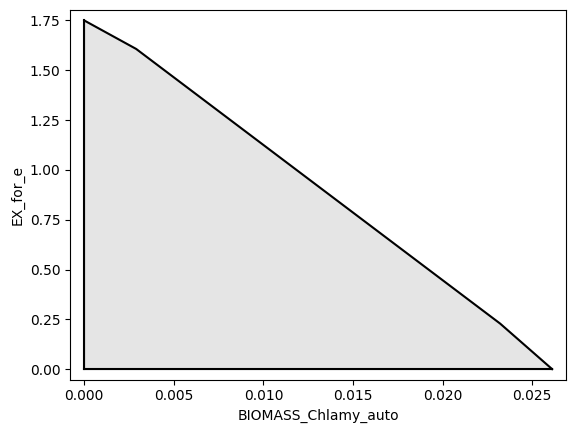

In [31]:
simul_aeroauto = get_simulator(model_aeroauto)
plot_flux_envelope(simul_aeroauto,'BIOMASS_Chlamy_auto', 'EX_for_e', substrate = "EX_co2_e" )

#### Condição 2

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_auto', ylabel='EX_for_e'>

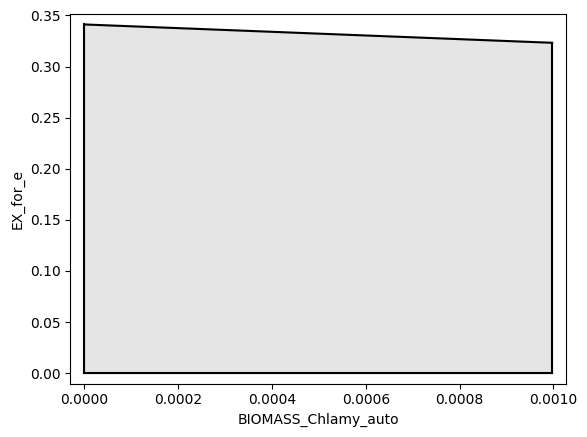

In [34]:
simul_microauto = get_simulator(model_microauto)
plot_flux_envelope(simul_microauto,'BIOMASS_Chlamy_auto', 'EX_for_e', substrate = "EX_co2_e" )

#### Condição 3

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_hetero', ylabel='EX_for_e'>

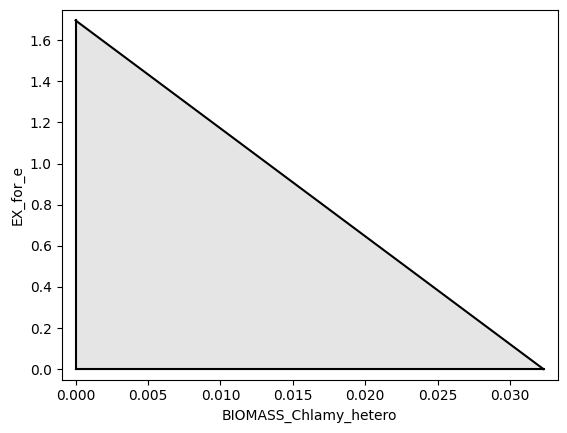

In [39]:
simul_aerohet = get_simulator(model_aerohet)
plot_flux_envelope(simul_aerohet,'BIOMASS_Chlamy_hetero', 'EX_for_e', substrate = "EX_ac_e" )

#### Condição 4

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_hetero', ylabel='EX_for_e'>

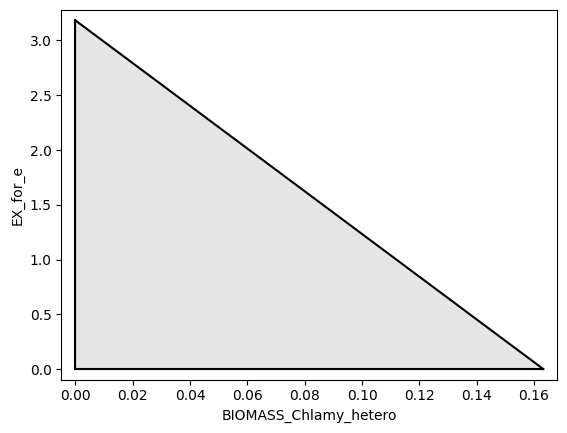

In [40]:
simul_microhet = get_simulator(model_microhet)
plot_flux_envelope(simul_microhet,'BIOMASS_Chlamy_hetero', 'EX_for_e', substrate = "EX_ac_e" )

#### Condição 5

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_mixo', ylabel='EX_for_e'>

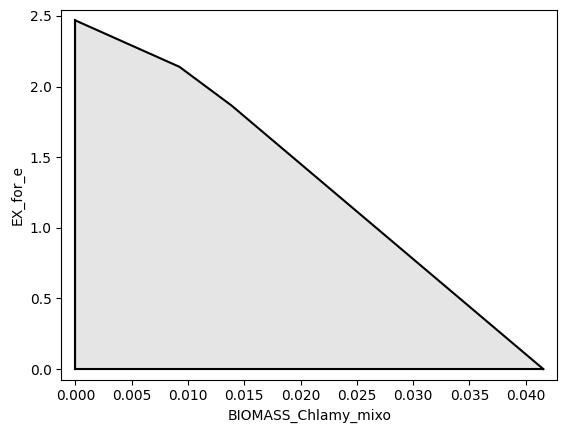

In [41]:
simul_aeromixo = get_simulator(model_aeromixo)
plot_flux_envelope(simul_aeromixo,'BIOMASS_Chlamy_mixo', 'EX_for_e', substrate = "EX_ac_e" )

#### Condição 6

/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(df.loc[r_id][0]), float(df.loc[r_id][1])]
/home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/mewpy/simulation/cobra.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

<AxesSubplot:xlabel='BIOMASS_Chlamy_mixo', ylabel='EX_for_e'>

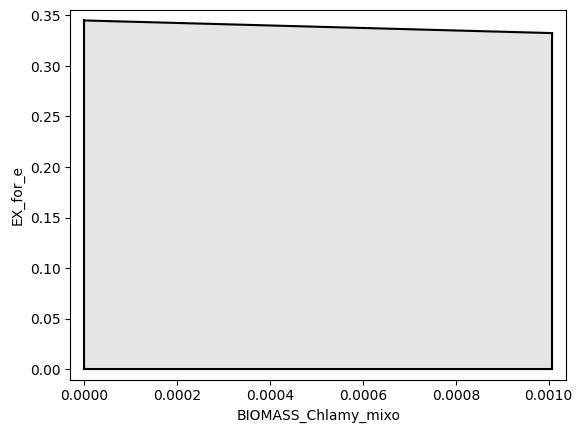

In [42]:
simul_micromixo = get_simulator(model_micromixo)
plot_flux_envelope(simul_micromixo,'BIOMASS_Chlamy_mixo', 'EX_for_e', substrate = 'EX_ac_e' and 'EX_co2_e' )

## **Exercício 2**

### Alínea A)

In [58]:
dados = pd.read_csv("expression_data1.tsv", sep="\t")
print(dados)

                  gene_id  Control_12h  Stress_12h  Stress_12_h2
0      Cre01.g000033.v5.5     2.916050   11.346800      2.074386
1      Cre01.g000250.v5.5    13.371200    2.516420      2.433566
2      Cre01.g000300.v5.5     2.535150    5.038200      1.149793
3      Cre01.g000150.v5.5    21.137000    0.776829      4.232645
4      Cre01.g000200.v5.5     2.031320   23.919400      1.719411
...                   ...          ...         ...           ...
17736  Cre52.g761647.v5.5   102.857000   13.758300      0.852842
17737  Cre50.g761497.v5.5    11.356900   89.962200      3.575397
17738  Cre51.g761547.v5.5     1.741490   11.924400      1.663222
17739  Cre51.g761597.v5.5     0.663041    2.329110      3.815924
17740  Cre48.g761197.v5.5     9.055890    0.933516      7.942931

[17741 rows x 4 columns]


In [65]:
coamb = {'EX_photonVis_e': 0,'EX_co2_e': -11.16,'EX_o2_e': -10, 'EX_ac_e': -10, 'SK_starch300_h': -0.000172}
simulacao = get_simulator(model, coamb)

In [66]:
# Retirar a coluna de Stress_12_h2
dados.drop('Stress_12_h2', axis = 1, inplace = True)

In [67]:
dados.index.values

array([    0,     1,     2, ..., 17738, 17739, 17740])

In [74]:
dados.columns

Index(['gene_id', 'Control_12h', 'Stress_12h'], dtype='object')

In [282]:
# Grupo Controlo
def expression_data_c(dados):
    genes = dados.gene_id
    conditions = ["Control_12h"]
    exp = dados[conditions].to_numpy()
    return genes, conditions, exp

expr_c = ExpressionSet(genes, conditions, exp)

try:
    ef_c = eFlux(model, expr)
except ValueError as e:
    handle_eflux_error(e)

def handle_eflux_error_c(e):
    if "max() arg is an empty sequence" in str(e):
        print("Os dados de expressão estão vazios para a condição especificada.")
    else:
        print(f"Erro na Simulação: {e}")

In [283]:
eflux_controlo = ef_c.dataframe
eflux_controlo.head()

,Flux rate
Reaction ID,
EX_urate_e,4.382049e-16
EX_no3_e,-1.004511e-03
EX_etoh_e,1.049548e-04
EX_for_e,4.217649e-04
EX_glyclt_e,-1.842639e-32


In [284]:
ef_c.fluxes

OrderedDict([('EX_hxan_e', 0.0),
             ('EX_alltn_e', 0.0),
             ('EX_orn_e', 0.0),
             ('EX_gln__L_e', 0.0),
             ('EX_urate_e', 4.3820485979648174e-16),
             ('EX_so3_e', 0.0),
             ('EX_s_e', 0.0),
             ('EX_no3_e', -0.001004511115028417),
             ('EX_so4_e', 0.0),
             ('EX_fe2_e', 0.0),
             ('EX_fe3_e', 0.0),
             ('PRISM_solar_litho', 0.0),
             ('PRISM_solar_exo', 0.0),
             ('PRISM_incandescent_60W', 0.0),
             ('EX_slnt_e', 0.0),
             ('EX_leu__L_e', 0.0),
             ('PRISM_fluorescent_warm_18W', 0.0),
             ('PRISM_fluorescent_cool_215W', 0.0),
             ('PRISM_metal_halide', 0.0),
             ('EX_etoh_e', 0.00010495482721836928),
             ('EX_arg__L_e', 0.0),
             ('EX_for_e', 0.00042176487290321817),
             ('EX_h2_e', 0.0),
             ('PRISM_high_pressure_sodium', 0.0),
             ('PRISM_growth_room', 0.0),
        

In [285]:
# Encontrar a reação relativa ao formato
ef_c.find(['EX_for_e'])

,Flux rate
Reaction ID,
EX_for_e,0.000422


In [287]:
# Grupo em Stress
def expression_data_s(dados):
    genes = dados.gene_id
    conditions = ["Stress_12h"]
    exp = dados[conditions].to_numpy()
    return genes, conditions, exp

expr_s = ExpressionSet(genes, conditions, exp)

try:
    ef_s = eFlux(model, expr)
except ValueError as e:
    handle_eflux_error(e)

def handle_eflux_error_s(e):
    if "max() arg is an empty sequence" in str(e):
        print("Os dados de expressão estão vazios para a condição especificada.")
    else:
        print(f"Erro na Simulação: {e}")

In [288]:
eflux_stress = ef_s.dataframe
eflux_stress.head()

,Flux rate
Reaction ID,
EX_urate_e,-3.403755e-16
EX_no3_e,-1.004511e-03
EX_etoh_e,1.049548e-04
EX_for_e,4.217649e-04
EX_succ_e,5.422723e-04


In [289]:
ef_s.fluxes

OrderedDict([('EX_hxan_e', 0.0),
             ('EX_alltn_e', 0.0),
             ('EX_orn_e', 0.0),
             ('EX_gln__L_e', 0.0),
             ('EX_urate_e', -3.4037548161505554e-16),
             ('EX_so3_e', 0.0),
             ('EX_s_e', 0.0),
             ('EX_no3_e', -0.001004511115028972),
             ('EX_so4_e', 0.0),
             ('EX_fe2_e', 0.0),
             ('EX_fe3_e', 0.0),
             ('PRISM_solar_litho', 0.0),
             ('PRISM_solar_exo', 0.0),
             ('PRISM_incandescent_60W', 0.0),
             ('EX_slnt_e', 0.0),
             ('EX_leu__L_e', 0.0),
             ('PRISM_fluorescent_warm_18W', 0.0),
             ('PRISM_fluorescent_cool_215W', 0.0),
             ('PRISM_metal_halide', 0.0),
             ('EX_etoh_e', 0.00010495482721532087),
             ('EX_arg__L_e', 0.0),
             ('EX_for_e', 0.0004217648728965166),
             ('EX_h2_e', 0.0),
             ('PRISM_high_pressure_sodium', 0.0),
             ('PRISM_growth_room', 0.0),
        

In [290]:
ef_s.find(['EX_for_e'])

,Flux rate
Reaction ID,
EX_for_e,0.000422


### Alínea B)

### Controlo vs Stress vs Wild-type 

|Controlo|Stress|
|-|-|
|1.3608e-14|-3.8876e-15|

Após uma análise dos valores obtidos relativamente à produção de Formato por parte da microalga *C. reinhairdtii* , utilizando o algortimo eFlux, é possível observar que a produção em condições condições controladas, foi superior à produção num ambiente de stress.


|Wild-type|
|-|
|-2.0258e-14 mmol/gDW/h|

Ao analisar os resultados das simulações com e sem integração de dados de expressão génica, é possível observar uma diferença entre os dados. O valor da produção de Formato em wild-type, ficou entre os valores apresentados em cima (Controlo e Stress, utilizando o eFlux).
Isto permite concluir que possivelmente existiram processos de regulação genética e adaptação metabólica que influenciaram de maneira significativa as vias metabólicas relacionadas com a produção de formato. 


## **Exercício 3)**

### Alínea A)

In [308]:
sim = get_simulator(model)

rea_essen = sim.essential_reactions()
rea_essen

100%|██████████| 2191/2191 [00:56<00:00, 38.49it/s]


['EX_hxan_e',
 'EX_alltn_e',
 'EX_orn_e',
 'EX_gln__L_e',
 'EX_urate_e',
 'EX_so3_e',
 'EX_s_e',
 'EX_no3_e',
 'EX_so4_e',
 'EX_fe2_e',
 'EX_fe3_e',
 'PRISM_solar_litho',
 'PRISM_solar_exo',
 'PRISM_incandescent_60W',
 'EX_slnt_e',
 'EX_leu__L_e',
 'PRISM_fluorescent_warm_18W',
 'PRISM_fluorescent_cool_215W',
 'PRISM_metal_halide',
 'EX_etoh_e',
 'EX_arg__L_e',
 'EX_for_e',
 'EX_h2_e',
 'PRISM_high_pressure_sodium',
 'PRISM_growth_room',
 'PRISM_white_LED',
 'EX_glyclt_e',
 'CMPth',
 'EX_succ_e',
 'EX_lac__D_e',
 'EX_6mpur_e',
 'PRISM_red_LED_array_653nm',
 'PRISM_red_LED_674nm',
 'PRISM_design_growth',
 'EX_h_e',
 'EX_h2o_e',
 'EX_pi_e',
 'EX_nh4_e',
 'EX_mg2_e',
 'EX_tgua_e',
 'EX_tega_e',
 'EX_5flura_e',
 'EX_cital_e',
 'EX_lido_e',
 'PS_asn__L_c',
 'CY_focytc_h',
 'CY_focytb5_c',
 'BIOMASS_Chlamy_auto',
 'EX_na1_e',
 'EX_photonVis_e',
 'EX_o2_e',
 'BIOMASS_Chlamy_mixo',
 'CO2th',
 'BIOMASS_Chlamy_hetero',
 'EX_co2_e',
 'COAth',
 'CTPth',
 'ATPM',
 'DM_apotfen_h',
 'DM_asnglcnacglcn

In [309]:
gen_essen = sim.essential_genes()
gen_essen

100%|██████████| 1086/1086 [00:32<00:00, 33.84it/s]


['CRv4_Au5_s46_g11918_t1',
 'CRv4_Au5_s1_g2400_t1',
 'CRv4_Au5_s16_g6082_t1',
 'CRv4_Au5_s16_g6506_t1',
 'CRv4_Au5_s16_g6473_t1',
 'CRv4_Au5_s16_g6245_t1',
 'CRv4_Au5_s2_g9288_t1',
 'CRv4_Au5_s16_g6246_t1',
 'CRv4_Au5_s6_g13541_t1',
 'CRv4_Au5_s9_g15209_t1',
 'CRv4_Au5_s9_g15368_t1',
 'CRv4_Au5_s19_g8092_t1',
 'CRv4_Au5_s17_g7007_t1',
 'CRv4_Au5_s2_g9136_t1',
 'CRv4_Au5_s13_g4791_t1',
 'CRv4_Au5_s10_g33_t1',
 'CRv4_Au5_s20_g8200_t1',
 'CRv4_Au5_s13_g4561_t1',
 'CRv4_Au5_s3_g10596_t1',
 'CRv4_Au5_s26_g9997_t1',
 'CRv4_Au5_s16_g6247_t1',
 'CRv4_Au5_s26_g9996_t1',
 'CRv4_Au5_s1_g2299_t1',
 'CRv4_Au5_s14_g5515_t1',
 'CRv4_Au5_s6_g12862_t1',
 'CRv4_Au5_s9_g15789_t1',
 'CRv4_Au5_s15_g5921_t1',
 'CRv4_Au5_s10_g542_t1',
 'CRv4_Au5_s2_g8924_t1',
 'CRv4_Au5_s12_g3125_t1',
 'CRv4_Au5_s10_g542_t2',
 'CRv4_Au5_s8_g14736_t1',
 'CRv4_Au5_s6_g12602_t1',
 'CRv4_Au5_s14_g5398_t1',
 'CRv4_Au5_s4_g11803_t1',
 'CRv4_Au5_s16_g6512_t1',
 'CRv4_Au5_s4_g11849_t1',
 'CRv4_Au5_s7_g14228_t1',
 'CRv4_Au5_s10_g680_

### Alínea B)

In [3]:
model = cobra.io.read_sbml_model("iRC1080_lv3.xml")
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,10,2,100.00%
mg2_e,EX_mg2_e,0.1848,0,0.00%
na1_e,EX_na1_e,10,0,0.00%
nh4_e,EX_nh4_e,10,0,0.00%
no3_e,EX_no3_e,10,0,0.00%
o2_e,EX_o2_e,5.815,0,0.00%
photonVis_e,EX_photonVis_e,1401,0,0.00%
pi_e,EX_pi_e,6.565,0,0.00%
so4_e,EX_so4_e,0.23,0,0.00%
starch300_h,SK_starch300_h,0.198,0,0.00%


In [4]:
# Definir o target
PRODUCT_ID = 'EX_for_e'
BIOMASS_ID = 'BIOMASS_Chlamy_hetero'

In [5]:
# Objetivos da otimização
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='lMOMA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

In [6]:
problem = RKOProblem(model, 
               fevaluation=[evaluator_1, evaluator_2], 
              )

In [7]:
problem = ROUProblem(model, 
               fevaluation=[evaluator_1, evaluator_2], 
               )

2024-01-01 16:20:24,881	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8270 


Using 40 workers.
Running NSGAII


(RayActor pid=2943311) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
(RayActor pid=2943311)   warn(f"Solver status is '{status}'.", UserWarning)
(RayActor pid=2945573) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'. [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RayActor pid=2945573)   warn(f"Solver status is '{status}'.", UserWarning) [repeated 9x across cluster]
(RayActor pid=2943318) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'. [repeated 3x across cluster]
(RayActor pid=2943318)   warn(f"Solver status is '{status}'.", UserWarning) [repeated 3x across cl

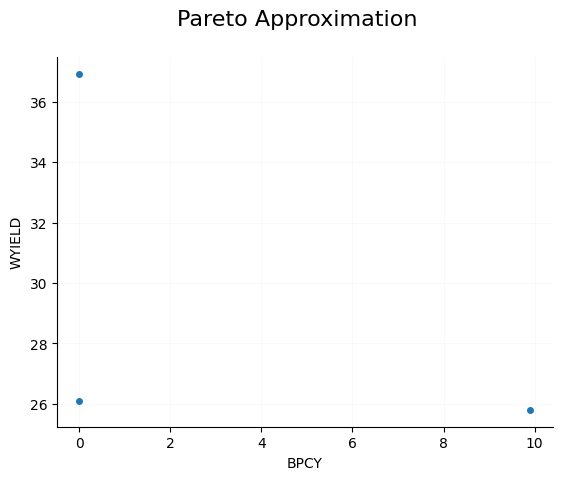

(RayActor pid=2943315) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'. [repeated 3x across cluster]
(RayActor pid=2943315)   warn(f"Solver status is '{status}'.", UserWarning) [repeated 3x across cluster]
(RayActor pid=2943312) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'. [repeated 8x across cluster]
(RayActor pid=2943312)   warn(f"Solver status is '{status}'.", UserWarning) [repeated 8x across cluster]
(RayActor pid=2943319) /home/ecunha/miniforge3/envs/test/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'. [repeated 3x across cluster]
(RayActor pid=2943319)   warn(f"Solver status is '{status}'.", UserWarning) [repeated 3x across cluster]


In [ ]:
# Otimização
from mewpy.optimization import EA
ea = EA(problem, max_generations= 100, visualizer=True)
final_pop = ea.run(simplify=False)